# Notebook 4: Kilimanjaro Safaris EDA & Modeling

Capstone Project, Nadia W. Morgen

## Data & Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pmd
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import meanabs

import time

import pickle

# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()  
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


In [2]:
safari_posted = pd.read_csv('data/safari_posted.csv')

In [3]:
safari_posted.dtypes

date         object
datetime     object
SACTMIN     float64
SPOSTMIN    float64
weekday       int64
day_name     object
dtype: object

In [4]:
safari_posted.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name
0,2015-01-01,2015-01-01 07:47:26,NaN,5.0,4,Thursday
1,2015-01-01,2015-01-01 07:54:23,NaN,5.0,4,Thursday
2,2015-01-01,2015-01-01 08:05:33,NaN,5.0,4,Thursday
3,2015-01-01,2015-01-01 08:12:23,NaN,10.0,4,Thursday
4,2015-01-01,2015-01-01 08:19:26,NaN,10.0,4,Thursday


I have to reconvert the fields into my desired datatypes and reestablish date as the index.

In [5]:
safari_posted['date'] = pd.to_datetime(safari_posted['date'])
safari_posted['datetime'] = pd.to_datetime(safari_posted['datetime'])

# Add column for day of the week
safari_posted['weekday'] = safari_posted['date'].dt.dayofweek

# Adjust index so Monday == 1
safari_posted['weekday'] = safari_posted['weekday'] + 1

safari_posted['day_name'] = safari_posted['date'].dt.day_name()
safari_posted['day_name'] = safari_posted.day_name.astype('string')


# Also creating two dataframes, one indexed on date, the other indexed on datetime
# This makes future computations much easier
safari_date = safari_posted.copy()
safari_date.set_index('date', inplace=True)


safari_dt = safari_posted.copy()
safari_dt.set_index('datetime', inplace = True)


# Breakup up data into precovid and covid-era
# precovid_daily includes wait times with daily means
precovid_daily = safari_posted.copy()
precovid_daily['date2'] = precovid_daily['date']

covid = safari_posted.copy()
covid['date2'] = covid['date']
covid = covid[covid['date'] > '2019-07-15']

# precovid includes all rows for each day during covid
# each day has roughly 1 row for every 7 min the ride was open
precovid = safari_posted.copy()
precovid = precovid[precovid['date'] < '2020-01-01']

safari_posted.set_index('date', inplace = True)

# EDA - Kilimanjaro Safaris

## Overview

As with the other rides, the data are imperfect.  There are days when there are multiple values recorded and days where there are none.  We see the most missing data in 2020 and 2021.  A large chunk of that was due to park closures due to COVID.  However, this doesn't explain the gap between Jan, 2021 and July, 2021.

### Wait Times Since Ride Opened

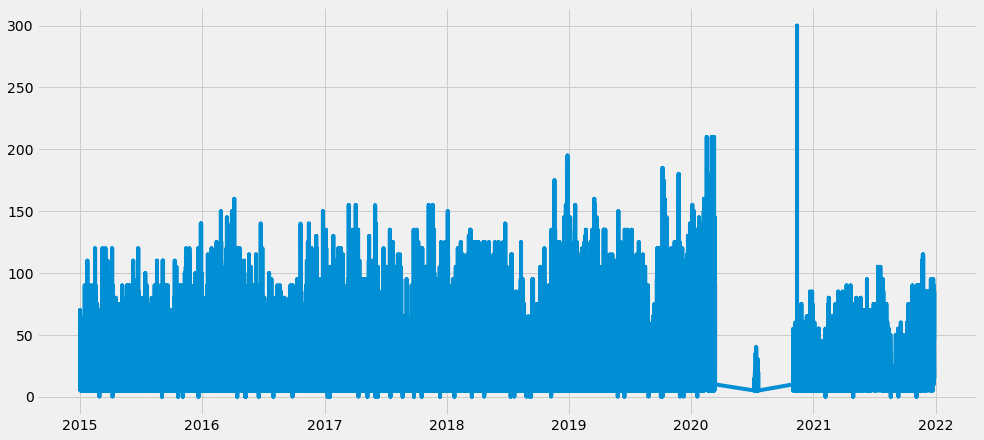

In [6]:
# Plot all wait times
plt.figure(figsize = (15, 7))
plt.plot(safari_posted['SPOSTMIN']);

In [7]:
safari_posted.tail(50)

,datetime,SACTMIN,SPOSTMIN,weekday,day_name
date,,,,,
2021-12-28,2021-12-28 11:45:31,NaN,80.0,2,Tuesday
2021-12-28,2021-12-28 11:50:22,NaN,80.0,2,Tuesday
2021-12-28,2021-12-28 11:56:32,NaN,75.0,2,Tuesday
2021-12-28,2021-12-28 12:06:21,NaN,75.0,2,Tuesday
2021-12-28,2021-12-28 12:07:29,NaN,70.0,2,Tuesday
2021-12-28,2021-12-28 12:18:12,NaN,70.0,2,Tuesday
2021-12-28,2021-12-28 12:24:13,NaN,70.0,2,Tuesday
2021-12-28,2021-12-28 12:30:17,NaN,70.0,2,Tuesday
2021-12-28,2021-12-28 12:36:12,NaN,70.0,2,Tuesday


In [8]:
print(f"Minimum Wait: {safari_posted['SPOSTMIN'].min()}")
print(f"Maximum Wait: {safari_posted['SPOSTMIN'].max()}")

Minimum Wait: 0.0
Maximum Wait: 300.0


Because of missing data and the covid closure (March 15 - July 11, 2020), I'm separating the precovid data from the covid data.  Because covid began affecting tourism prior to Disney's official closure, "precovid" is defined as prior to January 1, 2019.

In [9]:
precovid_daily.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2
0,2015-01-01,2015-01-01 07:47:26,NaN,5.0,4,Thursday,2015-01-01
1,2015-01-01,2015-01-01 07:54:23,NaN,5.0,4,Thursday,2015-01-01
2,2015-01-01,2015-01-01 08:05:33,NaN,5.0,4,Thursday,2015-01-01
3,2015-01-01,2015-01-01 08:12:23,NaN,10.0,4,Thursday,2015-01-01
4,2015-01-01,2015-01-01 08:19:26,NaN,10.0,4,Thursday,2015-01-01


In [10]:
# Limit data to precovid
precovid_daily = precovid_daily[precovid_daily.date2 < '2019-01-01']
precovid_daily.set_index('date', inplace=True)

# Group waiting times by date to get avg_daily_wait
precovid_daily['avg_daily_wait'] = precovid_daily.groupby('date2')['SPOSTMIN'].mean()
precovid_daily = precovid_daily.drop_duplicates(subset='date2', keep='last')
precovid_daily.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2015-01-01,2015-01-01 16:26:23,NaN,30.0,4,Thursday,2015-01-01,29.276316
2015-01-02,2015-01-02 16:32:23,NaN,10.0,5,Friday,2015-01-02,34.155844
2015-01-03,2015-01-03 16:47:23,NaN,10.0,6,Saturday,2015-01-03,19.551282
2015-01-04,2015-01-04 16:54:23,NaN,10.0,7,Sunday,2015-01-04,16.478873
2015-01-05,2015-01-05 16:54:24,NaN,10.0,1,Monday,2015-01-05,14.393939


In [11]:
# Perform same operations on covid data for testing
covid.set_index('date', inplace=True)

# Group waiting times by date to get avg_daily_posted_wait
covid['avg_daily_wait'] = covid.groupby('date2')['SPOSTMIN'].mean()
covid = covid.drop_duplicates(subset='date2', keep='last')
covid.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2019-07-16,2019-07-16 20:59:01,NaN,10.0,2,Tuesday,2019-07-16,50.217391
2019-07-17,2019-07-17 20:59:02,NaN,10.0,3,Wednesday,2019-07-17,45.346535
2019-07-18,2019-07-18 22:31:02,NaN,15.0,4,Thursday,2019-07-18,36.359649
2019-07-19,2019-07-19 20:59:01,NaN,15.0,5,Friday,2019-07-19,38.200000
2019-07-20,2019-07-20 20:59:02,NaN,25.0,6,Saturday,2019-07-20,42.596154


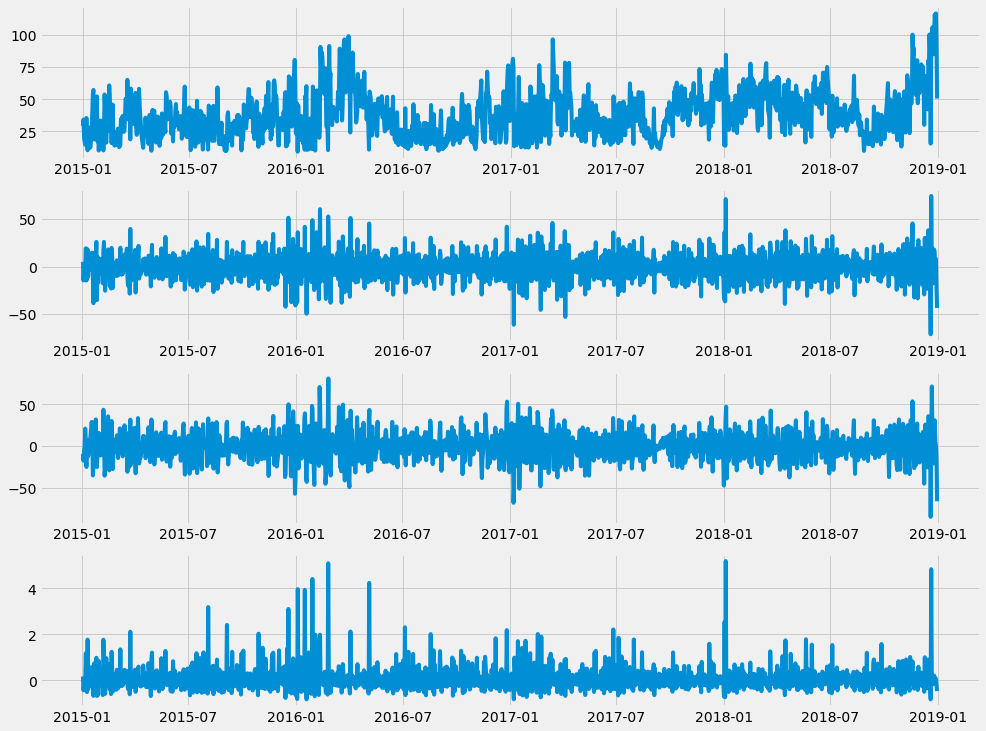

In [12]:
fig, axes = plt.subplots(nrows = 4, figsize = (15, 12))
axes[0].plot(precovid_daily['avg_daily_wait'])
axes[1].plot(precovid_daily['avg_daily_wait'].diff())
axes[2].plot(precovid_daily['avg_daily_wait'].diff(2))
axes[3].plot(precovid_daily['avg_daily_wait'].pct_change());

Top plot: Daily mean wait time
2nd plot: Daily mean wait time differenced once
3rd plot: Daily mean wait time differenced twice
4th plot: Percent change of daily mean wait time

There are some indications of seasonality.  Note that time 0 = the day the ride opened, so that can be ignored.  But there are spikes in December, 2017 and December, 2019.  Covid might explain the lack of a spike in December, 2018.  Although the parks were open, global travel was ebbing, particularly travel from Asia.

The 4th plot (percent difference) indicates a spike in November.  This could be due to Thanksgiving as well as the beginning of summer holidays for countries in the Southern hemisphere.

Ultimately, there is some evidence of seasonality that I will investigate further in the modeling section.

Given the lack of stationarity in the plots above, and given the nature of Disney's business, I need to explore the data for hourly "seasonality," weekly "seasonality," and possibly monthly "seasonality."

### Covid vs. Precovid

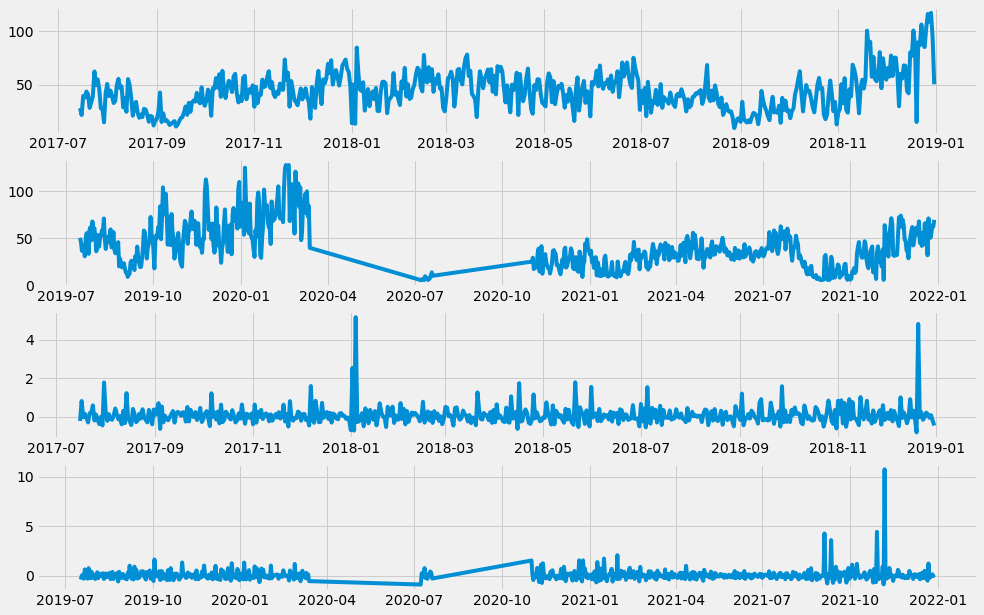

In [13]:
# to facilitate comparison, I'm starting both datasets at the same month for these plots.

precovid_daily_July = precovid_daily[precovid_daily['date2'] > '2017-07-14']

fig, axes = plt.subplots(nrows = 4, figsize = (15, 10))
axes[0].plot(precovid_daily_July['avg_daily_wait'])
axes[1].plot(covid['avg_daily_wait'])
axes[2].plot(precovid_daily_July['avg_daily_wait'].pct_change())
axes[3].plot(covid['avg_daily_wait'].pct_change());

## Day of the Week Seasonality

I would expect longer wait times on weekends, when locals and especially annual passholders are most likely to visit the park.  This is likely to have changed during covid after annual pass rules changed in 2021.

In 2021, Disney overhauled their annual passholder program.  In addition to steep price hikes, they require reservations for annual pass holders to ensure they won't exceed their lower park capacity (anywhere from  25%-50% of regular capacity, depending on the timing of the visit and the pandemic).  Reservations do not cost extra, but lower level passholders have limits on the number of reservations they can make each month; they also have additional blockout dates they never had before.

In [14]:
# Check for Seasonality Based on Day of the week
# Calculate average daily wait based on day of the week (all Mondays, etc.)

av_wait_by_day_of_week = precovid_daily.groupby('day_name')['avg_daily_wait'].mean()
av_wait_by_day_of_week

day_name
Friday       37.682292
Monday       38.491653
Saturday     40.320386
Sunday       38.459921
Thursday     37.118806
Tuesday      37.827128
Wednesday    33.906049
Name: avg_daily_wait, dtype: float64

Average daily wait time for the Klimanjaro Safaris was just over an hour before COVID.  Based on this summary, Wednesdays have the shortest average wait and Saturdays have the longest.  However, when ride waits exceed 1 hour, do 8 minutes make a substantial, qualitative difference to riders?  Or are they more likely to opt out or buy an individual Lightning Lane pass to skip the line?

In [15]:
# Covid-era seasonality based on day of the week
av_wait_by_day_of_week = covid.groupby('day_name')['avg_daily_wait'].mean()
av_wait_by_day_of_week

day_name
Friday       38.513137
Monday       41.067692
Saturday     43.823380
Sunday       46.232262
Thursday     39.173716
Tuesday      40.091365
Wednesday    35.806592
Name: avg_daily_wait, dtype: float64

Again, there's a minor difference in wait time among days.  Wednesdays have the shortest wait and Saturdays the longest, with a difference of about 7.5 minutes.  These numbers reflect the data plotted above.

## Hourly Seasonality

Is there a time of day when the ride has significantly shorter or longer wait times?  I'll examine data for a Wednesday (when the average wait was shortest) and a Saturday (when average wait was longest) and look for hourly trends.

In [16]:
# Step 1: Filter data for one day
# This was the Wednesday after Thanksgiving, 2018

safari_Wed_Dec_05 = precovid[precovid['date'] == '2018-12-5']
safari_Wed_Dec_05.set_index('datetime', inplace = True)

In [17]:
print(f"Minimum wait: {safari_Wed_Dec_05['SPOSTMIN'].min()}")
print(f"Maximum wait: {safari_Wed_Dec_05['SPOSTMIN'].max()}")

Minimum wait: 5.0
Maximum wait: 115.0


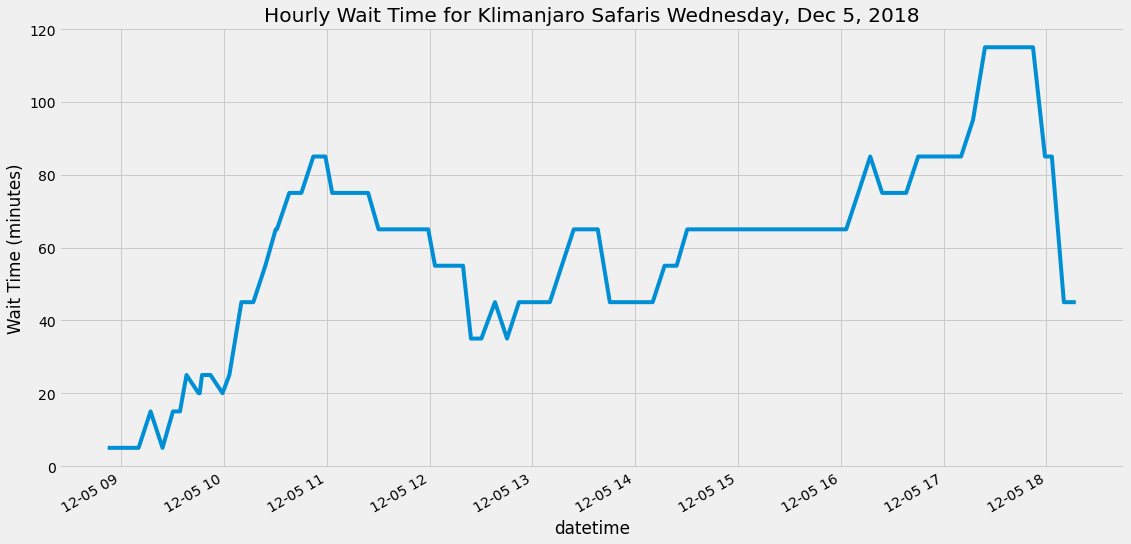

In [18]:
# Step 2: Plot hourly data for Wednesday, Dec 5, 2018

plt.figure(figsize = (17, 9))
plt.title("Hourly Wait Time for Klimanjaro Safaris Wednesday, Dec 5, 2018")
plt.xlabel('Time of Day')
plt.ylabel('Wait Time (minutes)')

# Set title and labels for axes

safari_Wed_Dec_05['SPOSTMIN'].plot();

If guests don't want to purchase an individual Lightning Lane pass for this ride, they should arrive at the park early and ride it first.  The wait time in the evening goes down also, but staff close the ride entrance before the park closes, so that riders are off the ride by closing time.  Remember, this is a lower-volume Wednesday.

In [19]:
# Step 3: Create data for Saturday, Dec 8, 2018

safari_Sat_Dec_08 = precovid[precovid['date'] == '2018-12-8']
safari_Sat_Dec_08.set_index('datetime', inplace = True)

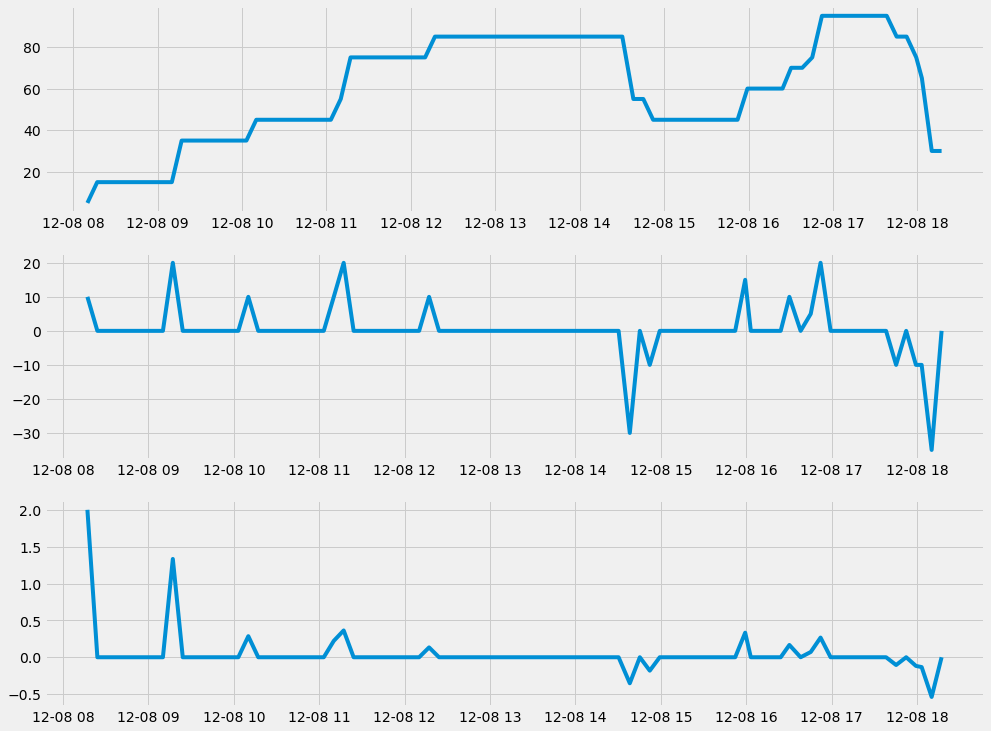

In [20]:
# Step 4: Plot hourly data for Saturday, Dec 8, 2018

# Plot unchanged, differenced, and percent change
fig, axes = plt.subplots(nrows = 3, figsize = (15, 12))
axes[0].plot(safari_Sat_Dec_08['SPOSTMIN'])
axes[1].plot(safari_Sat_Dec_08['SPOSTMIN'].diff())
axes[2].plot(safari_Sat_Dec_08['SPOSTMIN'].pct_change());

In [21]:
print(f"Minimum wait: {safari_Sat_Dec_08['SPOSTMIN'].min()}")
print(f"Maximum wait: {safari_Sat_Dec_08['SPOSTMIN'].max()}")

Minimum wait: 5.0
Maximum wait: 95.0


The two hourly plots differ substantially.  The Wednesday plot shows thw wait time spiking shortly after the ride opens and remaining long until shortly before the ride closes.  The Saturday plot has several ebbs and flows, including two (around 10AM and 5-5:30PM) when the wait time drops to about 50 minutes.  Is this typical for Saturdays?  Or is this just the pattern on this particular Saturday?

The second and third subplots show differenced data and percent change data respectively.  The differenced data still show the dips evident in the original data.  The bottom two subplots look very similar.  The data are not stationary for Saturday, Dec 8, 2018.

Comparing these two days provided no additional insight.  I need to compare all Saturdays to all Wednesdays to get a better idea if hourly seasonality exists.

In [22]:
# Step 5: Create df for Saturdays only
safari_Sat_Dec_08 = precovid[precovid['date'] == '2018-12-8']
saturdays = precovid.copy()

saturdays = saturdays[saturdays['day_name'] == 'Saturday']
saturdays.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name
153,2015-01-03,2015-01-03 07:47:23,NaN,5.0,6,Saturday
154,2015-01-03,2015-01-03 07:54:25,NaN,5.0,6,Saturday
155,2015-01-03,2015-01-03 08:05:24,NaN,10.0,6,Saturday
156,2015-01-03,2015-01-03 08:12:23,NaN,10.0,6,Saturday
157,2015-01-03,2015-01-03 08:19:29,NaN,10.0,6,Saturday


In [23]:
# Step 6: Create df for Wednesdays only
wednesdays = precovid.copy()

wednesdays = wednesdays[wednesdays['day_name'] == 'Wednesday']
wednesdays.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name
435,2015-01-07,2015-01-07 08:31:15,NaN,5.0,3,Wednesday
436,2015-01-07,2015-01-07 08:32:15,NaN,5.0,3,Wednesday
437,2015-01-07,2015-01-07 09:26:21,NaN,10.0,3,Wednesday
438,2015-01-07,2015-01-07 09:32:23,NaN,10.0,3,Wednesday
439,2015-01-07,2015-01-07 09:40:23,NaN,10.0,3,Wednesday


In [24]:
import time

saturdays['time'] = [d.time() for d in saturdays['datetime']]
wednesdays['time'] = [d.time() for d in wednesdays['datetime']]

In [25]:
saturdays.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name,time
153,2015-01-03,2015-01-03 07:47:23,NaN,5.0,6,Saturday,07:47:23
154,2015-01-03,2015-01-03 07:54:25,NaN,5.0,6,Saturday,07:54:25
155,2015-01-03,2015-01-03 08:05:24,NaN,10.0,6,Saturday,08:05:24
156,2015-01-03,2015-01-03 08:12:23,NaN,10.0,6,Saturday,08:12:23
157,2015-01-03,2015-01-03 08:19:29,NaN,10.0,6,Saturday,08:19:29


In [26]:
saturdays.dtypes

date        datetime64[ns]
datetime    datetime64[ns]
SACTMIN            float64
SPOSTMIN           float64
weekday              int64
day_name            string
time                object
dtype: object

In [27]:
temp_time = datetime.strptime('08:00:00', '%H:%M:%S').time()
saturdays = saturdays[saturdays['time'] > temp_time]
saturdays.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name,time
155,2015-01-03,2015-01-03 08:05:24,NaN,10.0,6,Saturday,08:05:24
156,2015-01-03,2015-01-03 08:12:23,NaN,10.0,6,Saturday,08:12:23
157,2015-01-03,2015-01-03 08:19:29,NaN,10.0,6,Saturday,08:19:29
158,2015-01-03,2015-01-03 08:26:22,NaN,10.0,6,Saturday,08:26:22
159,2015-01-03,2015-01-03 08:32:22,NaN,10.0,6,Saturday,08:32:22


In [28]:
saturdays.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name,time
155,2015-01-03,2015-01-03 08:05:24,NaN,10.0,6,Saturday,08:05:24
156,2015-01-03,2015-01-03 08:12:23,NaN,10.0,6,Saturday,08:12:23
157,2015-01-03,2015-01-03 08:19:29,NaN,10.0,6,Saturday,08:19:29
158,2015-01-03,2015-01-03 08:26:22,NaN,10.0,6,Saturday,08:26:22
159,2015-01-03,2015-01-03 08:32:22,NaN,10.0,6,Saturday,08:32:22


In [29]:
temp_time = datetime.strptime('08:00:00', '%H:%M:%S').time()
wednesdays = wednesdays[wednesdays['time'] > temp_time]
wednesdays.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name,time
435,2015-01-07,2015-01-07 08:31:15,NaN,5.0,3,Wednesday,08:31:15
436,2015-01-07,2015-01-07 08:32:15,NaN,5.0,3,Wednesday,08:32:15
437,2015-01-07,2015-01-07 09:26:21,NaN,10.0,3,Wednesday,09:26:21
438,2015-01-07,2015-01-07 09:32:23,NaN,10.0,3,Wednesday,09:32:23
439,2015-01-07,2015-01-07 09:40:23,NaN,10.0,3,Wednesday,09:40:23


In [30]:
# resample to 10 min intervals to drop seconds and standardize across Saturdays
saturdays.set_index('datetime', inplace=True)
saturdays.resample('10min', loffset=pd.Timedelta('10min'))


/var/folders/pt/67q6zqvx64n047rqdkj_wx5c0000gn/T/ipykernel_20805/2061199249.py:3: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  saturdays.resample('10min', loffset=pd.Timedelta('10min'))


In [31]:
saturdays.dtypes

date        datetime64[ns]
SACTMIN            float64
SPOSTMIN           float64
weekday              int64
day_name            string
time                object
dtype: object

In [32]:
saturdays.head()

,date,SACTMIN,SPOSTMIN,weekday,day_name,time
datetime,,,,,,
2015-01-03 08:05:24,2015-01-03,NaN,10.0,6,Saturday,08:05:24
2015-01-03 08:12:23,2015-01-03,NaN,10.0,6,Saturday,08:12:23
2015-01-03 08:19:29,2015-01-03,NaN,10.0,6,Saturday,08:19:29
2015-01-03 08:26:22,2015-01-03,NaN,10.0,6,Saturday,08:26:22
2015-01-03 08:32:22,2015-01-03,NaN,10.0,6,Saturday,08:32:22


In [33]:
saturdays.set_index('time', inplace=True)


In [34]:
wednesdays.set_index('datetime', inplace=True)
wednesdays.resample('10min', loffset=pd.Timedelta('10min'))

/var/folders/pt/67q6zqvx64n047rqdkj_wx5c0000gn/T/ipykernel_20805/2490914169.py:2: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  wednesdays.resample('10min', loffset=pd.Timedelta('10min'))


In [35]:
wednesdays.head()

,date,SACTMIN,SPOSTMIN,weekday,day_name,time
datetime,,,,,,
2015-01-07 08:31:15,2015-01-07,NaN,5.0,3,Wednesday,08:31:15
2015-01-07 08:32:15,2015-01-07,NaN,5.0,3,Wednesday,08:32:15
2015-01-07 09:26:21,2015-01-07,NaN,10.0,3,Wednesday,09:26:21
2015-01-07 09:32:23,2015-01-07,NaN,10.0,3,Wednesday,09:32:23
2015-01-07 09:40:23,2015-01-07,NaN,10.0,3,Wednesday,09:40:23


In [36]:
wednesdays.set_index('time', inplace=True)

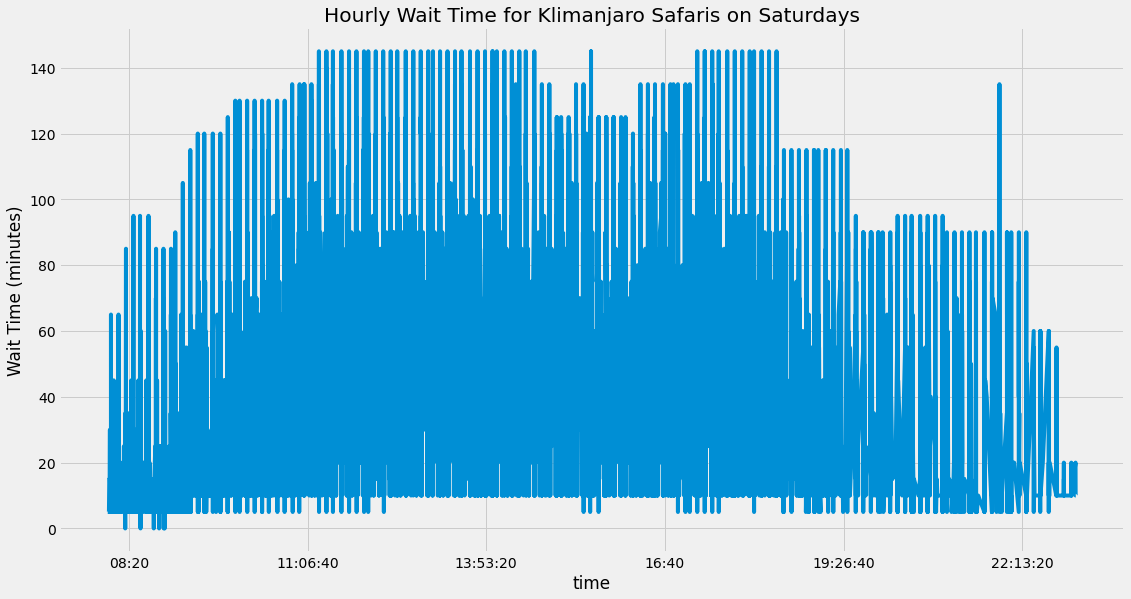

In [37]:
# Step 7: Plot hourly data for all Saturdays

plt.figure(figsize = (17, 9))
plt.title("Hourly Wait Time for Klimanjaro Safaris on Saturdays")
plt.xlabel('Time of Day')
plt.ylabel('Wait Time (minutes)')
# Set title and labels for axes

saturdays['SPOSTMIN'].plot();

There might be hourly seasonality for this ride, but the vast majority of wait times exceed 1hr, 40 minutes.  Therefore, in terms of guests' experience, the wait time differences mean little.  Of course, everyone has different tolerances for waiting, but people traveling from afar who are already spending thousands on a Disney vacation probably will prefer to pay $15 per person for Genie+ than spend a precious 1 hr and 40 min waiting for 1 ride.

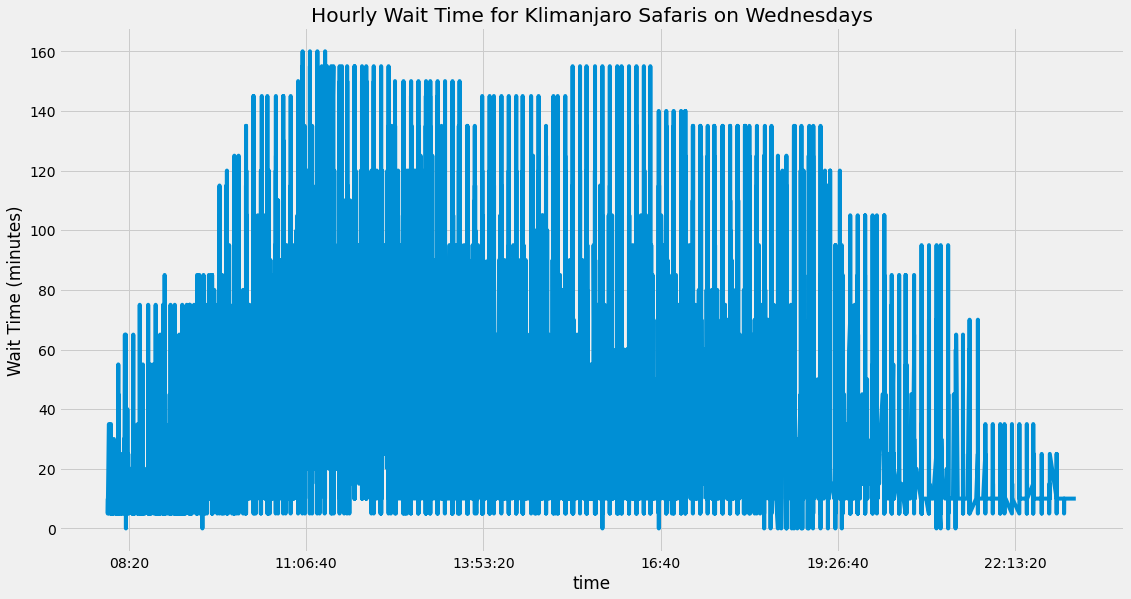

In [38]:
# Step 7: Plot hourly data for all Wednesdays

plt.figure(figsize = (17, 9))
plt.title("Hourly Wait Time for Klimanjaro Safaris on Wednesdays")
plt.xlabel('Time of Day')
plt.ylabel('Wait Time (minutes)')
# Set title and labels for axes

wednesdays['SPOSTMIN'].plot();

Overall, the darker pattern in this plot resembles the darker pattern in the Saturdays plot.  There might be hourly seasonality for this ride, but it's so popular that its wait times are at 2 hours by 9am.  Note that often the park opens at 9am.  In a few years, once the ride is no longer new, hourly seasonality might be something to revisit.  Currently, there might be hourly patterns, but any dips still indicate waits of 90 minutes or more until the end of the park day.

I see occasional gaps where the wait might be dropping (or it could be missing data for that time interval).  On the few days when the park was open late (Animal Kingdom is seldom open later than 8), wait times drop around 10pm.  Still, avoiding a 1 hour or more wait requires getting in line at the perfect time (approximately 10:30pm), which is a gamble, since they will close the ride before the wait oversteps the park's closure.  Much of Animal Kingdom is less viewable after dark.  Klimanjaro Safaris is an indoor ride, so it's unaffected by outside darkness.  And, of course, families with younger children won't want to stay this late, so Avatar fans should strongly consider purchasing an individual Lightning Lane pass for this ride.

## Weekly Seasonality

Weekly seasonality must be considered, but it's tricky because spring break and Thanksgiving dates shift each year.  Spring break dates can shift by as much as 6 weeks.  Therefore, a customized approach is warranted.

First, I'll number each week of the year, beginning with the day after the Christmas - New Year's blockout dates end.  Week numbers for the first year will align with the calendar, aside from the brief offset for New Year's blockout dates.  For subsequent years, spring break weeks - as defined by Disney's blockout dates - will be switched to align with the first years.  In other words, spring breaks will always have the same week numbers, regardless of where they fall in the calendar.  I'll do the same with Thanksgiving and, if necessary, Christmas.

I realize this isn't a perfect system.  K-12 school districts tend to align to Easter; colleges and universities do not.  However, using Disney's self-declared blockout dates for lower-level passholders makes the system as equivalent as possible.

Another issue with this method is covid's timing.  Klimanjaro Safaris opened May 26, 2017, so it was only open for 1.5 years before covid began impacting tourism.  Therefore, for this ride and for Flight of Passage, I'll focus solely on August 1 - Dec 31 of 2017, 2018, 2019, and 2020.

In [39]:
precovid.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name
0,2015-01-01,2015-01-01 07:47:26,NaN,5.0,4,Thursday
1,2015-01-01,2015-01-01 07:54:23,NaN,5.0,4,Thursday
2,2015-01-01,2015-01-01 08:05:33,NaN,5.0,4,Thursday
3,2015-01-01,2015-01-01 08:12:23,NaN,10.0,4,Thursday
4,2015-01-01,2015-01-01 08:19:26,NaN,10.0,4,Thursday


In [40]:
# safari_Sat_Dec_08 = precovid[precovid['date'] == '2018-12-8']

In [41]:
# copy dataframe for backup
precovid_weekly = precovid_daily.copy()

# create day number
precovid_weekly['day_num'] = range(0, len(precovid_weekly))

# use day number to create and calculate week number
precovid_weekly['week_num'] = (precovid_weekly['day_num'] // 7)

# copy dataframe before indexing for future use
precovid_weekly_2 = precovid_weekly.copy()

# Create two copies: one for future indexing and one for other uses
precovid_weekly['week_number'] = precovid_weekly['week_num']

precovid_weekly.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,week_num,week_number
date,,,,,,,,,,
2015-01-01,2015-01-01 16:26:23,NaN,30.0,4,Thursday,2015-01-01,29.276316,0,0,0
2015-01-02,2015-01-02 16:32:23,NaN,10.0,5,Friday,2015-01-02,34.155844,1,0,0
2015-01-03,2015-01-03 16:47:23,NaN,10.0,6,Saturday,2015-01-03,19.551282,2,0,0
2015-01-04,2015-01-04 16:54:23,NaN,10.0,7,Sunday,2015-01-04,16.478873,3,0,0
2015-01-05,2015-01-05 16:54:24,NaN,10.0,1,Monday,2015-01-05,14.393939,4,0,0


In [42]:
# set index to week number
precovid_weekly.set_index('week_num', inplace=True)

# groupby week
precovid_weekly['avg_weekly_wait'] = precovid_weekly.groupby('week_num')['avg_daily_wait'].mean()

precovid_weekly['date'] = precovid_weekly['date2']

# set index to date
precovid_weekly.set_index('date', inplace=True)

# delete duplicates
precovid_weekly.drop_duplicates(subset='week_number', keep = 'last', inplace=True)

precovid_weekly.shape

(208, 10)

In [43]:
precovid_weekly.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,week_number,avg_weekly_wait
date,,,,,,,,,,
2015-01-07,2015-01-07 16:54:22,NaN,10.0,3,Wednesday,2015-01-07,35.390625,6,0,23.634416
2015-01-14,2015-01-14 17:00:09,NaN,10.0,3,Wednesday,2015-01-14,12.857143,13,1,16.768268
2015-01-21,2015-01-21 17:00:07,NaN,10.0,3,Wednesday,2015-01-21,32.436975,20,2,35.127385
2015-01-28,2015-01-28 13:14:09,NaN,10.0,3,Wednesday,2015-01-28,10.000000,27,3,24.881711
2015-02-04,2015-02-04 17:15:05,NaN,10.0,3,Wednesday,2015-02-04,27.731092,34,4,24.877385


In [44]:
# Had to copy data first before limiting by date.  Didn't work when I tried to combine steps.
Aug17 = precovid_weekly.copy()
Aug18 = precovid_weekly.copy()

Aug17 = Aug17[Aug17['date2'] > '2017-07-31']
Aug17 = Aug17[Aug17['date2'] <= '2017-12-31']
Aug18 = Aug18[Aug18['date2'] > '2018-07-31']
Aug18 = Aug18[Aug18['date2'] <= '2018-12-31']

In [45]:
Aug18.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,week_number,avg_weekly_wait
date,,,,,,,,,,
2018-08-07,2018-08-07 21:30:08,NaN,10.0,2,Tuesday,2018-08-07,45.087719,1308,186,40.263683
2018-08-14,2018-08-14 21:30:10,NaN,10.0,2,Tuesday,2018-08-14,44.703390,1315,187,43.872634
2018-08-21,2018-08-21 21:30:09,NaN,5.0,2,Tuesday,2018-08-21,21.982759,1322,188,35.518324
2018-08-28,2018-08-28 20:30:10,NaN,10.0,2,Tuesday,2018-08-28,9.716981,1329,189,23.347726
2018-09-04,2018-09-04 20:30:11,NaN,5.0,2,Tuesday,2018-09-04,16.120690,1336,190,19.572131


In [46]:
# Between covid and the ride opening in May, 2017, week_number in all Aug dfs must be 
# calibrated to be in sync with each other

Aug17['week_number'] = Aug17['week_number'] - 9
Aug18['week_number'] = Aug18['week_number'] - 61

In [47]:
Aug18.head(20)

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,week_number,avg_weekly_wait
date,,,,,,,,,,
2018-08-07,2018-08-07 21:30:08,NaN,10.0,2,Tuesday,2018-08-07,45.087719,1308,125,40.263683
2018-08-14,2018-08-14 21:30:10,NaN,10.0,2,Tuesday,2018-08-14,44.703390,1315,126,43.872634
2018-08-21,2018-08-21 21:30:09,NaN,5.0,2,Tuesday,2018-08-21,21.982759,1322,127,35.518324
2018-08-28,2018-08-28 20:30:10,NaN,10.0,2,Tuesday,2018-08-28,9.716981,1329,128,23.347726
2018-09-04,2018-09-04 20:30:11,NaN,5.0,2,Tuesday,2018-09-04,16.120690,1336,129,19.572131
2018-09-11,2018-09-11 20:30:10,NaN,5.0,2,Tuesday,2018-09-11,21.064815,1343,130,19.297153
2018-09-18,2018-09-18 19:59:08,NaN,5.0,2,Tuesday,2018-09-18,20.943396,1350,131,27.629999
2018-09-25,2018-09-25 20:03:06,NaN,15.0,2,Tuesday,2018-09-25,30.576923,1357,132,27.156630
2018-10-02,2018-10-02 19:59:07,NaN,15.0,2,Tuesday,2018-10-02,18.932039,1364,133,26.460621


In [48]:
# Thanksgiving, 2017 = Nov 23; Thanksgiving, 2018 = Nov 22.  They have the same week number.

In [49]:
# copy dataframe for backup
covid_weekly = covid.copy()


# create day number
covid_weekly['day_num'] = range(0, len(covid_weekly))

# use day number to create and calculate week number
covid_weekly['week_num'] = (covid_weekly['day_num'] // 7)

# copy dataframe before indexing for future use
covid_weekly_2 = covid_weekly.copy()

covid_weekly['week_number'] = covid_weekly['week_num']

# Group waiting times by date to get avg_daily_posted_wait
covid_weekly['avg_daily_wait'] = covid_weekly.groupby('date2')['SPOSTMIN'].mean()

# set index to week number
covid_weekly.set_index('week_num', inplace=True)

# groupby week
covid_weekly['avg_weekly_wait'] = covid_weekly.groupby('week_num')['avg_daily_wait'].mean()

covid_weekly['date'] = covid_weekly['date2']

# set index to date
covid_weekly.set_index('date', inplace=True)

# delete duplicates
covid_weekly.drop_duplicates(subset='week_number', keep = 'last', inplace=True)

covid_weekly.head()


,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,week_number,avg_weekly_wait
date,,,,,,,,,,
2019-07-22,2019-07-22 20:59:01,NaN,10.0,1,Monday,2019-07-22,10.0,6,0,13.571429
2019-07-29,2019-07-29 20:59:02,NaN,10.0,1,Monday,2019-07-29,10.0,13,1,15.000000
2019-08-05,2019-08-05 20:59:02,NaN,15.0,1,Monday,2019-08-05,15.0,20,2,13.571429
2019-08-12,2019-08-12 20:52:02,NaN,10.0,1,Monday,2019-08-12,10.0,27,3,9.285714
2019-08-19,2019-08-19 20:24:02,NaN,15.0,1,Monday,2019-08-19,15.0,34,4,12.142857


In [50]:
Aug19 = covid_weekly.copy()
Aug20 = covid_weekly.copy()

Aug19 = Aug19[Aug19['date2'] > '2019-07-31']
Aug19 = Aug19[Aug19['date2'] <= '2019-12-31']
Aug20 = Aug20[Aug20['date2'] > '2020-07-31']
Aug20 = Aug20[Aug20['date2'] <= '2020-12-31']

# Offsets needed to sync up Thanksgiving to same week number (roughly)
Aug19['week_number'] = Aug19['week_number'] - 2
Aug20['week_number'] = Aug20['week_number'] - 24

In [51]:
Aug20.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,week_number,avg_weekly_wait
date,,,,,,,,,,
2020-11-04,2020-11-04 17:10:01,NaN,10.0,3,Wednesday,2020-11-04,10.0,258,12,7.142857
2020-11-11,2020-11-11 16:59:02,NaN,10.0,3,Wednesday,2020-11-11,10.0,265,13,15.714286
2020-11-18,2020-11-18 16:59:01,NaN,10.0,3,Wednesday,2020-11-18,10.0,272,14,19.285714
2020-11-25,2020-11-25 16:59:01,NaN,35.0,3,Wednesday,2020-11-25,35.0,279,15,28.571429
2020-12-02,2020-12-02 16:59:01,NaN,10.0,3,Wednesday,2020-12-02,10.0,286,16,18.571429


### Weekly EDA

In [52]:
precovid_weekly.set_index('date2', inplace=True)

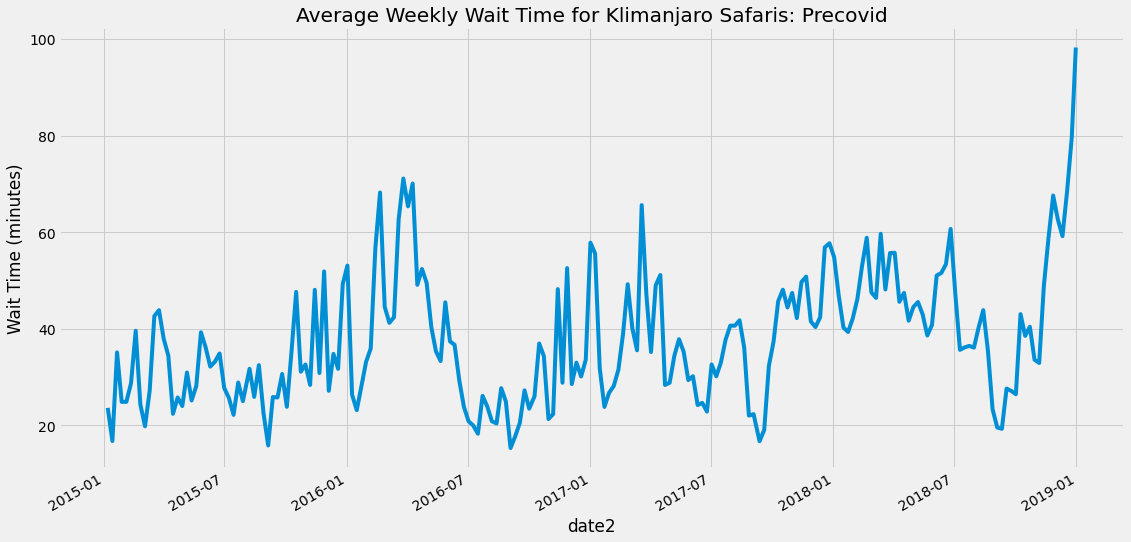

In [53]:
plt.figure(figsize = (17, 9))
plt.title("Average Weekly Wait Time for Klimanjaro Safaris: Precovid")
plt.xlabel('Date')
plt.ylabel('Wait Time (minutes)')
# Set title and labels for axes

precovid_weekly['avg_weekly_wait'].plot();

There is definite weekly fluctuation, but it doesn't appear to form a clear pattern.  The major spike at December, 2017 is due to higher park attendance at Christmas. There are similar, though smaller, spikes in November and December, 2018.  In Florida, summer vacation begins in mid-May and ends in early to mid-August.  The smaller spikes in late May, 2018 and 2019 likely are due to summer vacation for local schoolchildren.

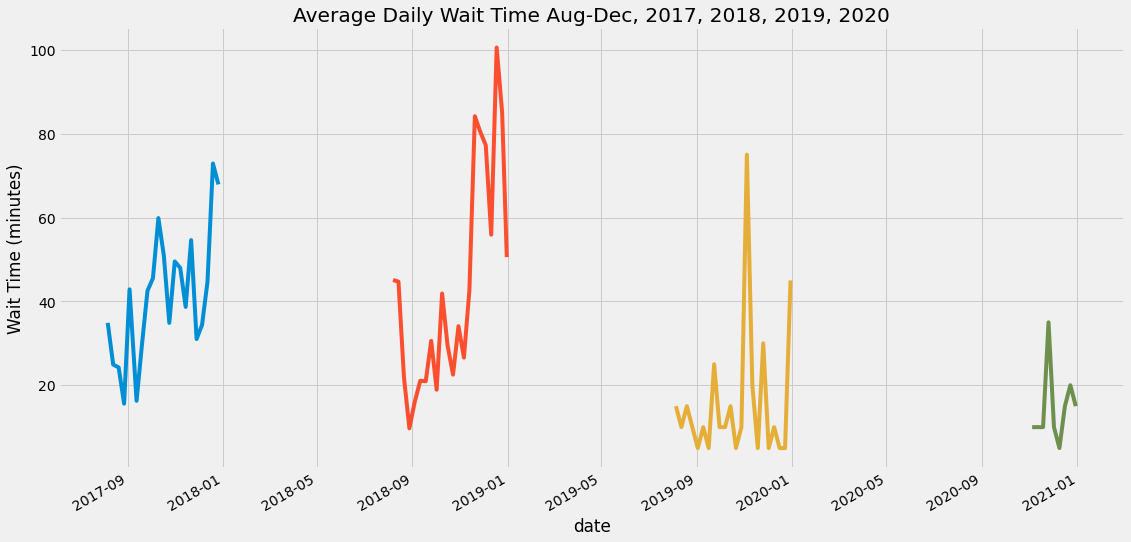

In [54]:
plt.figure(figsize = (17, 9))
plt.title("Average Daily Wait Time Aug-Dec, 2017, 2018, 2019, 2020")
plt.xlabel('Date')
plt.ylabel('Wait Time (minutes)')
# Set title and labels for axes

Aug17['avg_daily_wait'].plot()
Aug18['avg_daily_wait'].plot()
Aug19['avg_daily_wait'].plot()
Aug20['avg_daily_wait'].plot();

The trends appear very similar.  December 2018 and 2020 appear more affected by covid than December 2020.  At least in Autumn, there is seasonality.  The biggest difference among the plots is that average daily wait time decreased each year from 2017-2019 and leveled off in 2020.

In [55]:
Aug17.set_index('week_number', inplace=True)
Aug18.set_index('week_number', inplace=True)
Aug19.set_index('week_number', inplace=True)
Aug20.set_index('week_number', inplace=True)

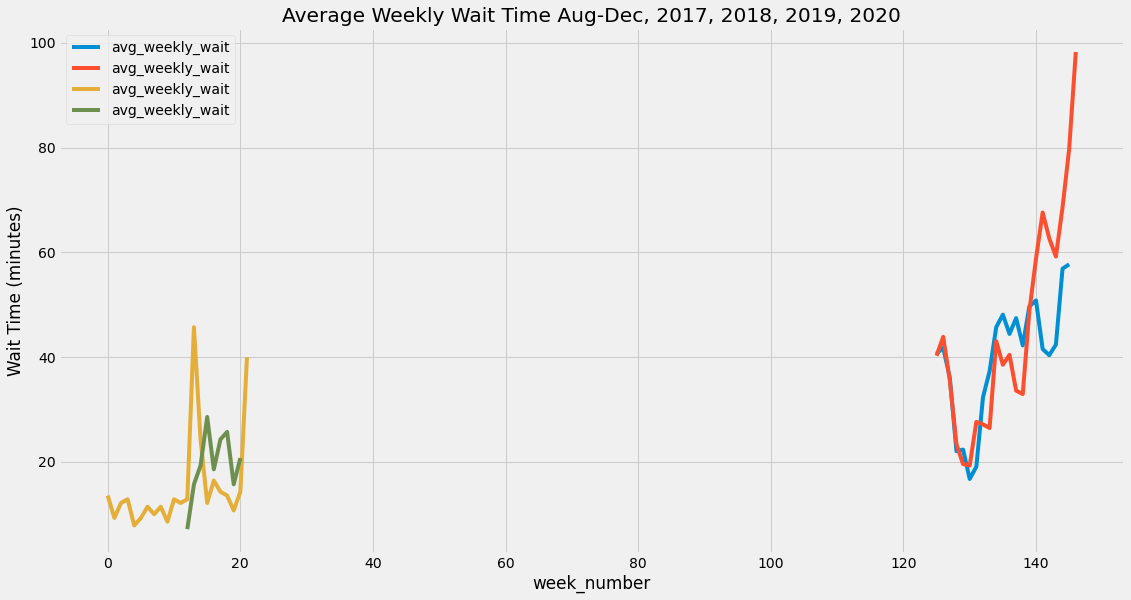

In [56]:
plt.figure(figsize = (17, 9))
plt.title("Average Weekly Wait Time Aug-Dec, 2017, 2018, 2019, 2020")
plt.xlabel('Date')
plt.ylabel('Wait Time (minutes)')
# Set title and labels for axes

Aug17['avg_weekly_wait'].plot()
Aug18['avg_weekly_wait'].plot()
Aug19['avg_weekly_wait'].plot()
Aug20['avg_weekly_wait'].plot()
plt.legend();

By calibrating all years by week number, I can plot the average daily wait times on the same graph.  2017 and 2018 look very similar.  Wait times were higher in 2017, but since the ride was new in 2017, that makes sense.  The lower spike at the end of 2018 could be due to covid.  Covid began impacting tourism, especially from Asia, by the end of 2018.

2020 is missing a lot of data, but what is available roughly follows the pattern of 2019.  

# Modeling

## Precovid Null Model

In [57]:
# Overall average wait time before covid
precovid['SPOSTMIN'].mean()

41.01087406181668

In this case, the null model is the mean wait time before covid, or 70 minutes.  I calculated this figure using the original data but excluding all dates after March 15, 2020.

In [58]:
precovid_weekly_2 = precovid_weekly.copy()

In [59]:
# for prediction purposes, I want a one year dataset unaffected by covid and the ride's grand opening
precovid_weekly_2 = precovid_weekly_2[precovid_weekly_2['datetime'] > '2017-08-01']
precovid_weekly_2 = precovid_weekly_2[precovid_weekly_2['datetime'] < '2018-08-01']
precovid_weekly_2.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,avg_daily_wait,day_num,week_number,avg_weekly_wait
date2,,,,,,,,,
2017-08-06,2017-08-06 21:59:06,NaN,15.0,7,Sunday,34.876033,944,134,40.663560
2017-08-13,2017-08-13 21:59:06,NaN,5.0,7,Sunday,24.920000,951,135,41.767658
2017-08-20,2017-08-20 21:30:12,NaN,10.0,7,Sunday,24.243697,958,136,36.071780
2017-08-27,2017-08-27 21:30:10,NaN,10.0,7,Sunday,15.598291,965,137,22.036256
2017-09-03,2017-09-03 21:03:07,NaN,10.0,7,Sunday,42.869565,972,138,22.342565


In [60]:
precovid_weekly_2.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,avg_daily_wait,day_num,week_number,avg_weekly_wait
date2,,,,,,,,,
2017-08-06,2017-08-06 21:59:06,NaN,15.0,7,Sunday,34.876033,944,134,40.663560
2017-08-13,2017-08-13 21:59:06,NaN,5.0,7,Sunday,24.920000,951,135,41.767658
2017-08-20,2017-08-20 21:30:12,NaN,10.0,7,Sunday,24.243697,958,136,36.071780
2017-08-27,2017-08-27 21:30:10,NaN,10.0,7,Sunday,15.598291,965,137,22.036256
2017-09-03,2017-09-03 21:03:07,NaN,10.0,7,Sunday,42.869565,972,138,22.342565


## Covid Null Model

In [61]:
# Overall average wait time during covid
covid_null = covid[covid['date2'] < '2021-09-01']
covid_null['SPOSTMIN'].mean()

14.767441860465116

In [62]:
covid.head(3)

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2019-07-16,2019-07-16 20:59:01,NaN,10.0,2,Tuesday,2019-07-16,50.217391
2019-07-17,2019-07-17 20:59:02,NaN,10.0,3,Wednesday,2019-07-17,45.346535
2019-07-18,2019-07-18 22:31:02,NaN,15.0,4,Thursday,2019-07-18,36.359649


## ACF and PACF Plots

### 1 Year Plots

All of these plots use data that starts in August, 2017.

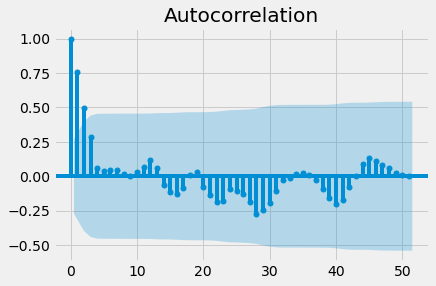

In [63]:
# Weekly ACF plot for May 26, 2017 - May 26, 2018: pre-covid
# X-axis = week number
plot_acf(precovid_weekly_2['avg_weekly_wait'], lags=51)
plt.show()

This plot shows indications of seasonality, with significant autocorrelation for almost 4 weeks, followed by what looks like a subtle cosine curve.

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


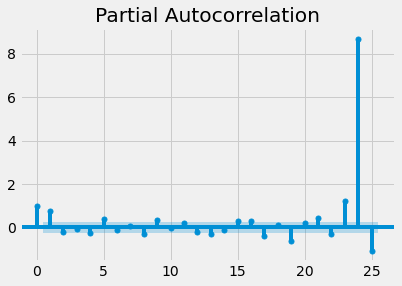

In [64]:
# Weekly PACF plot for May 26, 2017 - May 26, 2018: pre-covid
plot_pacf(precovid_weekly_2['avg_weekly_wait'], lags=25)
plt.show()

The partial autocorrelation plot also shows indications of seasonality, roughly 6 months after August.  Aside from a positive blip for Presidents' Day week, February is a pretty quiet month for Disney.

### 90 Day ACF and PACF Plots

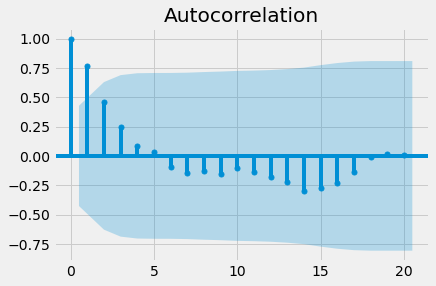

In [65]:
# 5 month plot, beginning Aug 1, 2017 (roughly 5 months)
plot_acf(Aug17['avg_weekly_wait'], lags=20)
plt.show()

Autocorrelation really only lasts for 2 weeks.  It flips from positive to negative in early October and only begins to approch zero again approaching New Year's.  Since the curve dips and increases again, this might be evidence of seasonality.

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


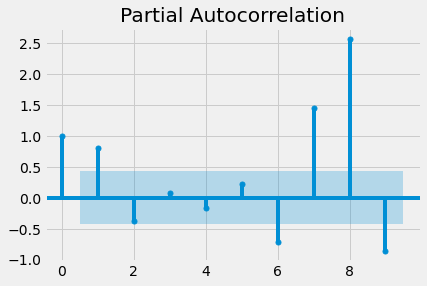

In [66]:
# 13 Week plot beginning Aug 1, 2017 (roughly 3 months)
plot_pacf(Aug17['avg_weekly_wait'], lags=9)
plt.show()

Partial autocorrelation is only observed the first two weeks (as expected) and then negatively at the 8th interval.

In [67]:
Aug18.head(25)

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,avg_weekly_wait
week_number,,,,,,,,,
125,2018-08-07 21:30:08,NaN,10.0,2,Tuesday,2018-08-07,45.087719,1308,40.263683
126,2018-08-14 21:30:10,NaN,10.0,2,Tuesday,2018-08-14,44.703390,1315,43.872634
127,2018-08-21 21:30:09,NaN,5.0,2,Tuesday,2018-08-21,21.982759,1322,35.518324
128,2018-08-28 20:30:10,NaN,10.0,2,Tuesday,2018-08-28,9.716981,1329,23.347726
129,2018-09-04 20:30:11,NaN,5.0,2,Tuesday,2018-09-04,16.120690,1336,19.572131
130,2018-09-11 20:30:10,NaN,5.0,2,Tuesday,2018-09-11,21.064815,1343,19.297153
131,2018-09-18 19:59:08,NaN,5.0,2,Tuesday,2018-09-18,20.943396,1350,27.629999
132,2018-09-25 20:03:06,NaN,15.0,2,Tuesday,2018-09-25,30.576923,1357,27.156630
133,2018-10-02 19:59:07,NaN,15.0,2,Tuesday,2018-10-02,18.932039,1364,26.460621


### Decomposition

In [68]:
precovid_daily.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2015-01-01,2015-01-01 16:26:23,NaN,30.0,4,Thursday,2015-01-01,29.276316
2015-01-02,2015-01-02 16:32:23,NaN,10.0,5,Friday,2015-01-02,34.155844
2015-01-03,2015-01-03 16:47:23,NaN,10.0,6,Saturday,2015-01-03,19.551282
2015-01-04,2015-01-04 16:54:23,NaN,10.0,7,Sunday,2015-01-04,16.478873
2015-01-05,2015-01-05 16:54:24,NaN,10.0,1,Monday,2015-01-05,14.393939


<Figure size 432x288 with 0 Axes>

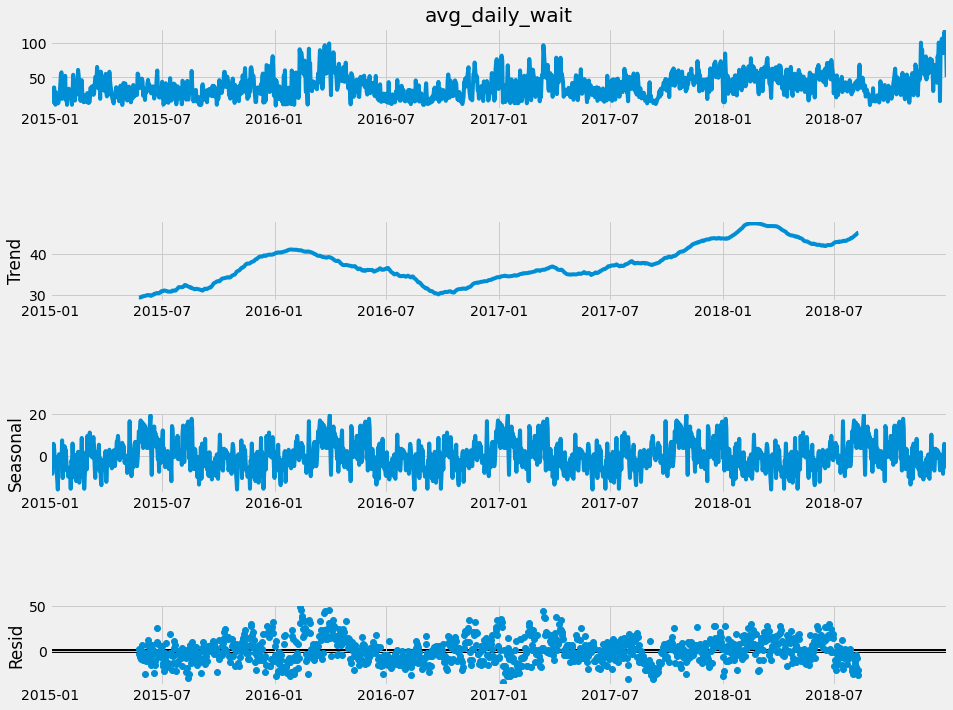

In [69]:
# Daily seasonality?

decomp_daily = seasonal_decompose(precovid_daily.avg_daily_wait, period = 289)
fig = plt.figure()
fig = decomp_daily.plot()
fig.set_size_inches(15, 12);

Decomposition of average daily wait times shows fluctuation, but not necessarily seasonality.  The residuals are pretty evenly distributed, aside from two spikes in Feb and March, 2016 and April, 2017.

<Figure size 432x288 with 0 Axes>

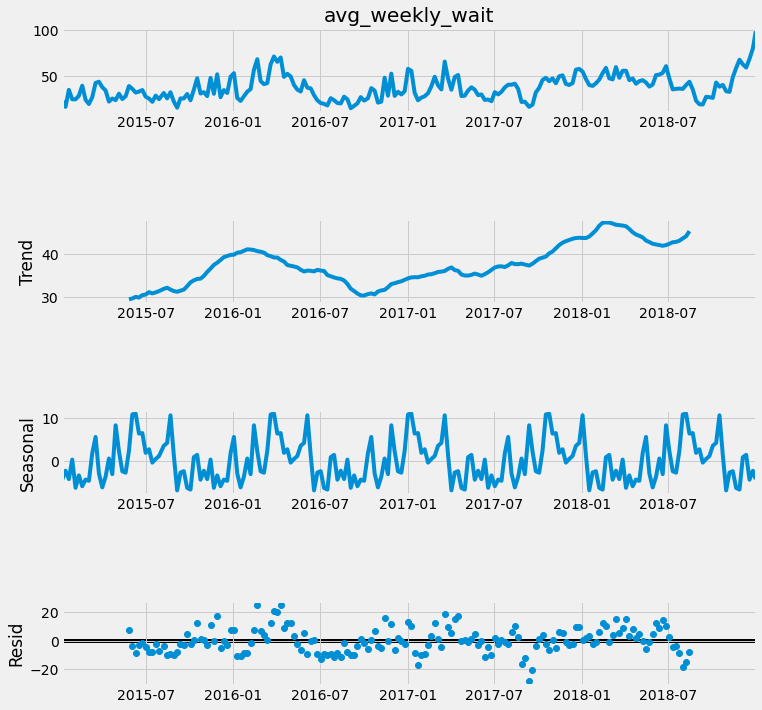

In [70]:
# Weekly seasonality?

decomp_weekly = seasonal_decompose(precovid_weekly.avg_weekly_wait, period = 41)
fig = plt.figure()
fig = decomp_weekly.plot()
fig.set_size_inches(12, 12);


The weekly decomposition plots look very similar to the daily decomposition plots.  The daily decomposition doesn't add any granularity.  Both plots show an overall, gradual increase in wait times over time.

In [71]:
precovid_weekly_3 = pd.DataFrame(precovid_weekly['avg_weekly_wait'])

# RESAMPLE SO SARIMAX WILL WORK (ride closures caused some irregularities)
precovid_weekly_3.resample('D').interpolate()[::7]

# from https://stackoverflow.com/questions/14530556/resample-time-series-in-pandas-to-a-weekly-interval

,avg_weekly_wait
date2,
2015-01-07,23.634416
2015-01-14,16.768268
2015-01-21,35.127385
2015-01-28,24.881711
2015-02-04,24.877385
...,...
2018-11-28,66.906630
2018-12-05,62.170053
2018-12-12,60.543371


In [72]:
covid_weekly_3 = pd.DataFrame(covid_weekly['avg_weekly_wait'])

# RESAMPLE SO SARIMAX WILL WORK (ride closures caused some irregularities)
covid_weekly_3.resample('D').interpolate()[::7]

# from https://stackoverflow.com/questions/14530556/resample-time-series-in-pandas-to-a-weekly-interval

,avg_weekly_wait
date,
2019-07-22,13.571429
2019-07-29,15.000000
2019-08-05,13.571429
2019-08-12,9.285714
2019-08-19,12.142857
...,...
2021-11-29,33.673469
2021-12-06,30.408163
2021-12-13,36.122449


In [73]:
# covid_weekly_3 = pd.DataFrame(covid_weekly['avg_weekly_wait'])

In [74]:
#covid.tail(50)

There are insufficient data and too many large gaps to predict wait times on a weekly basis, so I must use daily data.  The next question is which "precovid" data to use: 2018, 2019, or 2020?  The parks were closed from mid-March - mid-July, 2019.  Disney is still not running at full capacity, so if those data are availble, they might predict wait times better than 2018 data.  I lack the data for 2020, so that's not an option.

## Predict Wait Times for Autumn, 2021

### Option 1 (Null Model):
Remember, the null model is that guests will wait 29 minutes to ride this ride.

### Option 2: ARIMA

In [75]:
# for future use
y_train_sarimax = covid[covid['date2'] < '2019-12-29']

# Modify dfs to make them the same length[Aug 30 - Dec 28, 2021 & Aug 30 - Dec 28, 2019]
y_train = covid[covid['date2'] > '2019-08-29']
y_train = y_train[y_train['date2'] < '2019-12-29']
y_test = covid[covid['date2'] > '2021-08-29']

In [76]:
y_train.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2019-08-30,2019-08-30 20:24:02,NaN,10.0,5,Friday,2019-08-30,19.411765
2019-08-31,2019-08-31 20:24:02,NaN,15.0,6,Saturday,2019-08-31,23.118812
2019-09-01,2019-09-01 20:45:02,NaN,5.0,7,Sunday,2019-09-01,17.864583
2019-09-02,2019-09-02 20:31:01,NaN,5.0,1,Monday,2019-09-02,13.316832
2019-09-03,2019-09-03 14:31:03,NaN,10.0,2,Tuesday,2019-09-03,13.235294


In [77]:
y_test.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2021-08-30,2021-08-30 18:59:07,NaN,5.0,1,Monday,2021-08-30,5.656566
2021-08-31,2021-08-31 18:59:08,NaN,5.0,2,Tuesday,2021-08-31,5.200000
2021-09-01,2021-09-01 18:59:07,NaN,5.0,3,Wednesday,2021-09-01,5.245098
2021-09-02,2021-09-02 18:59:07,NaN,5.0,4,Thursday,2021-09-02,5.588235
2021-09-03,2021-09-03 18:59:08,NaN,5.0,5,Friday,2021-09-03,5.637255


Aug 30, 2019 was a Friday; Aug 30, 2021 was a Monday.  I need to modify the dataframes and index them by day_number (new field), so that the days of the week match up, even though actual dates will differ by a few days.

I would start y_train on Monday, Sept 2, 2019 instead of August 30, but that was Labor Day. Sept 6, 2021 was Labor Day.  There's no perfect way to adjust for this.  I'll manually recode the respective dates as Sundays instead of Mondays to predict crowds better.  The plots won't match, but in the final analysis (predicting actual wait times vs predicted), it will be fine.

In [78]:
# Add day_number and make it index in both dfs

y_train['day_number'] = range(1, 1 + len(y_train))
y_test['day_number'] = range(1, 1 + len(y_test))

y_train.set_index('day_number', inplace=True)
y_test.set_index('day_number', inplace=True)

/var/folders/pt/67q6zqvx64n047rqdkj_wx5c0000gn/T/ipykernel_20805/3422483454.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['day_number'] = range(1, 1 + len(y_test))


In [79]:
y_train

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
day_number,,,,,,,
1,2019-08-30 20:24:02,NaN,10.0,5,Friday,2019-08-30,19.411765
2,2019-08-31 20:24:02,NaN,15.0,6,Saturday,2019-08-31,23.118812
3,2019-09-01 20:45:02,NaN,5.0,7,Sunday,2019-09-01,17.864583
4,2019-09-02 20:31:01,NaN,5.0,1,Monday,2019-09-02,13.316832
5,2019-09-03 14:31:03,NaN,10.0,2,Tuesday,2019-09-03,13.235294
...,...,...,...,...,...,...,...
117,2019-12-24 18:24:02,NaN,25.0,2,Tuesday,2019-12-24,81.948052
118,2019-12-25 18:24:02,NaN,25.0,3,Wednesday,2019-12-25,68.000000
119,2019-12-26 18:24:02,NaN,30.0,4,Thursday,2019-12-26,69.767442


In [80]:
y_test

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
day_number,,,,,,,
1,2021-08-30 18:59:07,NaN,5.0,1,Monday,2021-08-30,5.656566
2,2021-08-31 18:59:08,NaN,5.0,2,Tuesday,2021-08-31,5.200000
3,2021-09-01 18:59:07,NaN,5.0,3,Wednesday,2021-09-01,5.245098
4,2021-09-02 18:59:07,NaN,5.0,4,Thursday,2021-09-02,5.588235
5,2021-09-03 18:59:08,NaN,5.0,5,Friday,2021-09-03,5.637255
...,...,...,...,...,...,...,...
117,2021-12-24 16:42:16,NaN,60.0,5,Friday,2021-12-24,50.172414
118,2021-12-25 16:42:18,NaN,45.0,6,Saturday,2021-12-25,55.057471
119,2021-12-26 16:42:17,NaN,50.0,7,Sunday,2021-12-26,63.275862


In [81]:
# For use in future, custom model
custom_21 = y_test.copy()

In [82]:
# These are daily data.
y_train = pd.DataFrame(y_train['avg_daily_wait'])
y_test = pd.DataFrame(y_test['avg_daily_wait'])

In [83]:
# From lesson 9.3, Hank Butler
# start with really high AIC, initialize p and q to zero
# loop through to find best aic, p, and q
# Starting AIC, p, and q.

best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):

        try:
            
            # Fitting an ARIMA(p, 1, q) model.
            print(f'Attempting to fit ARIMA({p}, 1, {q})')
            
            # Instantiate ARIMA model.
            arima = ARIMA(endog = y_train.astype(float).dropna(), # endog = y - variable
                         order = (p, 1, q)) # values of p, d, q
            
            
            # Fit ARIMA model.
            model = arima.fit()

            # Print out AIC for ARIMA(p, 1, q) model.
            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')

            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index

Attempting to fit ARIMA(0, 1, 0)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.22723D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   4.227D+00
  F =   4.2272313700304514     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The AIC for ARIMA(0,1,0) is: 1018.5355288073083
Attempting to fit ARIMA(0, 1, 1)


/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forec

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.19659D+00    |proj g|=  1.38538D-03

At iterate    5    f=  4.19658D+00    |proj g|=  7.99361D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     12      1     0     0   0.000D+00   4.197D+00
  F =   4.1965774093348847     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The AIC for ARIMA(0,1,1) is: 1013.1785782403724
Attempting to fit ARIMA(0, 1, 2)
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forec

The AIC for ARIMA(0,1,4) is: 1006.0511306781813
Attempting to fit ARIMA(1, 1, 0)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.20691D+00    |proj g|=  8.05667D-04

At iterate    5    f=  4.20691D+00    |proj g|=  2.51177D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     11      1     0     0   0.000D+00   4.207D+00
  F =   4.2069057710615274     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The AIC for ARIMA(1,1,0) is: 1015.6573850547667
Att

 This problem is unconstrained.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and

The AIC for ARIMA(1,1,2) is: 1003.7563996742845
Attempting to fit ARIMA(1, 1, 3)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.14082D+00    |proj g|=  5.28626D-03

At iterate    5    f=  4.14062D+00    |proj g|=  3.03517D-03

At iterate   10    f=  4.14060D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     16      1     0     0   8.882D-08   4.141D+00
  F =   4.1405963152454506     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignore

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.14352D+00    |proj g|=  4.80593D-03

At iterate    5    f=  4.14212D+00    |proj g|=  4.23777D-03

At iterate   10    f=  4.14112D+00    |proj g|=  6.15277D-03

At iterate   15    f=  4.14068D+00    |proj g|=  3.42393D-04

At iterate   20    f=  4.14067D+00    |proj g|=  4.69846D-05

At iterate   25    f=  4.14067D+00    |proj g|=  1.01874D-04

At iterate   30    f=  4.14067D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.



At iterate   10    f=  4.13950D+00    |proj g|=  7.00418D-04

At iterate   15    f=  4.13923D+00    |proj g|=  1.14707D-02

At iterate   20    f=  4.13881D+00    |proj g|=  1.71667D-03

At iterate   25    f=  4.13879D+00    |proj g|=  3.41949D-05

At iterate   30    f=  4.13879D+00    |proj g|=  1.31095D-04

At iterate   35    f=  4.13879D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     56      1     0     0   4.441D-07   4.139D+00
  F =   4.1387913208978686     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(2,1,2) is: 1005.3099170154884
Att

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.14225D+00    |proj g|=  1.09314D-02

At iterate    5    f=  4.13928D+00    |proj g|=  3.01483D-03

At iterate   10    f=  4.13907D+00    |proj g|=  1.39355D-03

At iterate   15    f=  4.13803D+00    |proj g|=  2.88738D-03

At iterate   20    f=  4.13797D+00    |proj g|=  2.29239D-04

At iterate   25    f=  4.13796D+00    |proj g|=  3.01092D-05

At iterate   30    f=  4.13796D+00    |proj g|=  4.97380D-06

At iterate   35    f=  4.13796D+00    |proj g|=  3.55271D-07

At iterate   40    f=  4.13796D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.10594D+00    |proj g|=  2.44589D-01

At iterate    5    f=  4.10091D+00    |proj g|=  4.32770D-02

At iterate   10    f=  4.09715D+00    |proj g|=  4.44151D-03

At iterate   15    f=  4.09692D+00    |proj g|=  1.58868D-03

At iterate   20    f=  4.09692D+00    |proj g|=  2.01617D-05

At iterate   25    f=  4.09692D+00    |proj g|=  8.88178D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     38      1     0     0   

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warni


At iterate   15    f=  4.14066D+00    |proj g|=  8.48743D-04

At iterate   20    f=  4.14061D+00    |proj g|=  6.49258D-05

At iterate   25    f=  4.14061D+00    |proj g|=  3.54383D-05

At iterate   30    f=  4.14061D+00    |proj g|=  8.32223D-05

At iterate   35    f=  4.14061D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     55      1     0     0   2.665D-07   4.141D+00
  F =   4.1406125519865249     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(3,1,1) is: 1005.747012476766
Attempting to fit ARIMA(3, 1, 2)


/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.14366D+00    |proj g|=  4.61364D-03

At iterate    5    f=  4.14203D+00    |proj g|=  8.43565D-03

At iterate   10    f=  4.14127D+00    |proj g|=  8.51577D-03

At iterate   15    f=  4.14023D+00    |proj g|=  8.76286D-03

At iterate   20    f=  4.13867D+00    |proj g|=  7.16920D-03

At iterate   25    f=  4.13800D+00    |proj g|=  1.49498D-03

At iterate   30    f=  4.13796D+00    |proj g|=  4.97913D-04

At iterate   35    f=  4.13796D+00    |proj g|=  1.82077D-05

At iterate   40    f=  4.13796D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


The AIC for ARIMA(3,1,2) is: 1007.1101307353143
Attempting to fit ARIMA(3, 1, 3)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.14529D+00    |proj g|=  6.80828D-01

At iterate    5    f=  4.13806D+00    |proj g|=  4.86464D-03

At iterate   10    f=  4.13761D+00    |proj g|=  1.70243D-02

At iterate   15    f=  4.13508D+00    |proj g|=  6.88664D-02

At iterate   20    f=  4.13302D+00    |proj g|=  1.42660D-01

At iterate   25    f=  4.13119D+00    |proj g|=  1.12368D-01

At iterate   30    f=  4.13092D+00    |proj g|=  4.03013D-01

At iterate   35    f=  4.13088D+00    |proj g|=  2.82801D-02

At iterate   40    f=  4.13088D+00    |proj g|=  4.29523D-04

At iterate   45    f=  4.13088D+00    |proj g|=  6.55298D-04

At iterate   50    f=  4.13088D+00    |proj g|=  2.74625D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   55    f=  4.13088D+00    |proj g|=  3.60600D-04
  ys=-2.182E-09  -gs= 3.840E-09 BFGS update SKIPPED

At iterate   60    f=  4.13088D+00    |proj g|=  4.42579D-04

At iterate   65    f=  4.13088D+00    |proj g|=  4.00637D-02

At iterate   70    f=  4.13088D+00    |proj g|=  3.29221D-03

At iterate   75    f=  4.13088D+00    |proj g|=  3.61196D-03

At iterate   80    f=  4.13088D+00    |proj g|=  2.57749D-04

At iterate   85    f=  4.13088D+00    |proj g|=  3.07017D-03

At iterate   90    f=  4.13088D+00    |proj g|=  7.66498D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   95    f=  4.13088D+00    |proj g|=  6.93436D-03

At iterate  100    f=  4.13088D+00    |proj g|=  2.75699D-03

At iterate  105    f=  4.13088D+00    |proj g|=  5.93481D-04

At iterate  110    f=  4.13088D+00    |proj g|=  1.57545D-03

At iterate  115    f=  4.13088D+00    |proj g|=  4.81482D-04

At iterate  120    f=  4.13088D+00    |proj g|=  3.91687D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  125    f=  4.13088D+00    |proj g|=  2.31992D-04

At iterate  130    f=  4.13088D+00    |proj g|=  4.17657D-03

At iterate  135    f=  4.13088D+00    |proj g|=  2.20890D-03

At iterate  140    f=  4.13088D+00    |proj g|=  5.45306D-03

At iterate  145    f=  4.13088D+00    |proj g|=  3.97664D-03

At iterate  150    f=  4.13088D+00    |proj g|=  1.81766D-03

At iterate  155    f=  4.13088D+00    |proj g|=  4.76064D-03

At iterate  160    f=  4.13088D+00    |proj g|=  4.34852D-04

At iterate  165    f=  4.13088D+00    |proj g|=  5.55467D-04

At iterate  170    f=  4.13088D+00    |proj g|=  2.12301D-03
  ys=-1.705E-10  -gs= 7.189E-11 BFGS update SKIPPED

At iterate  175    f=  4.13088D+00    |proj g|=  5.64526D-04

At iterate  180    f=  4.13088D+00    |proj g|=  7.02371D-04

At iterate  185    f=  4.13088D+00    |proj g|=  1.34914D-03

At iterate  190    f=  4.13088D+00    |proj g|=  3.19886D-03

At iterate  195    f=  4.13088D+00    |proj g|=  2.07727D-03

At iterate  200  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.10158D+00    |proj g|=  2.13704D-01

At iterate    5    f=  4.09835D+00    |proj g|=  4.28761D-02

At iterate   10    f=  4.09556D+00    |proj g|=  1.82405D-03

At iterate   15    f=  4.09546D+00    |proj g|=  3.82467D-03

At iterate   20    f=  4.09506D+00    |proj g|=  1.07106D-02

At iterate   25    f=  4.09498D+00    |proj g|=  9.62075D-04

At iterate   30    f=  4.09498D+00    |proj g|=  4.26326D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warni

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.14180D+00    |proj g|=  4.19194D-03

At iterate    5    f=  4.14166D+00    |proj g|=  1.31477D-03

At iterate   10    f=  4.14148D+00    |proj g|=  3.73035D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     16      1     0     0   2.665D-07   4.141D+00
  F =   4.1414775696584138     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(4,1,1) is: 1007.9546167180192
Attempting to fit ARIM

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.



At iterate   15    f=  4.14146D+00    |proj g|=  4.14424D-04

At iterate   20    f=  4.14146D+00    |proj g|=  4.61853D-06

At iterate   25    f=  4.14146D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     31      1     0     0   1.776D-07   4.141D+00
  F =   4.1414601017754391     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(4,1,2) is: 1009.9504244261053
Attempting to fit ARIMA(4, 1, 3)


/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09997D+00    |proj g|=  1.82145D-01

At iterate    5    f=  4.09648D+00    |proj g|=  2.45319D-02

At iterate   10    f=  4.09510D+00    |proj g|=  3.00995D-03

At iterate   15    f=  4.09507D+00    |proj g|=  3.79963D-03

At iterate   20    f=  4.09501D+00    |proj g|=  7.48646D-04

At iterate   25    f=  4.09500D+00    |proj g|=  1.29496D-04

At iterate   30    f=  4.09500D+00    |proj g|=  8.10907D-05

At iterate   35    f=  4.09500D+00    |proj g|=  9.76996D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09982D+00    |proj g|=  2.71272D-01

At iterate    5    f=  4.09475D+00    |proj g|=  5.16676D-02

At iterate   10    f=  4.09280D+00    |proj g|=  8.54277D-03

At iterate   15    f=  4.09248D+00    |proj g|=  1.79371D-02

At iterate   20    f=  4.09202D+00    |proj g|=  2.46221D-03

At iterate   25    f=  4.09195D+00    |proj g|=  2.15499D-03

At iterate   30    f=  4.09188D+00    |proj g|=  5.08393D-04

At iterate   35    f=  4.09188D+00    |proj g|=  1.11910D-05

At iterate   40    f=  4.09188D+00    |proj g|=  7.99361D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

In [84]:
# Since dataset is small, do manually.  No seasonality, just straight-up ARIMA
#factors = pmd.auto_arima(y_train['avg_daily_wait'], m=31, trace=True)

# best model = AIC = 999.2611; (2, 1, 4)

In [85]:
# Instantiate best model.
model = ARIMA(endog = y_train.astype(float).dropna(),
             order = (2, 1, 4))


# Fit ARIMA model.
arima = model.fit()

# Generate predictions based on test set.
preds = model.predict(params = arima.params,
                     start = y_test.index[0],
                     end = y_test.index[-1])



/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.10594D+00    |proj g|=  2.44589D-01

At iterate    5    f=  4.10091D+00    |proj g|=  4.32770D-02

At iterate   10    f=  4.09715D+00    |proj g|=  4.44151D-03

At iterate   15    f=  4.09692D+00    |proj g|=  1.58868D-03

At iterate   20    f=  4.09692D+00    |proj g|=  2.01617D-05

At iterate   25    f=  4.09692D+00    |proj g|=  8.88178D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     38      1     0     0   

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [86]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D.avg_daily_wait   No. Observations:                  120
Model:                 ARIMA(2, 1, 4)   Log Likelihood                -491.631
Method:                       css-mle   S.D. of innovations             14.238
Date:                Tue, 15 Feb 2022   AIC                            999.261
Time:                        17:21:30   BIC                           1021.561
Sample:                             1   HQIC                          1008.317
                                                                              
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.4099      0.395      1.039      0.299      -0.364       1.183
ar.L1.D.avg_daily_wait     0.9040      0.063     14.344      0.000       0.781       1.028
ar.L2.D.avg_daily_wait    -0.8626      0.060    -14.390      0.000      -0.980      -0.745
ma.L1.D.avg_daily_wait    -1.3113      0.099    -13.186      0.000      -1.506      -1.116
ma.L2.D.avg_daily_wait     1.1307      0.150      7.538      0.000       0.837       1.425
ma.L3.D.avg_daily_wait    -0.2672      0.153     -1.752      0.080      -0.566       0.032
ma.L4.D.avg_daily_wait    -0.2719      0.103     -2.627      0.009      -0.475      -0.069
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.5240           -0.9406j            1.0767           -0.1691
AR.2            0.5240           +0.9406j            1.0767            0.1691
MA.1            0.4105           -0.9119j            1.0000           -0.1827
MA.2            0.4105           +0.9119j            1.0000            0.1827
MA.3            1.2175           -0.0000j            1.2175           -0.0000
MA.4           -3.0213           -0.0000j            3.0213           -0.5000
-----------------------------------------------------------------------------
"""

In [87]:
# RMSE = .060 - .153, std error of constant = .395
# Based on the P values, the data are stationary (alpha = .05)

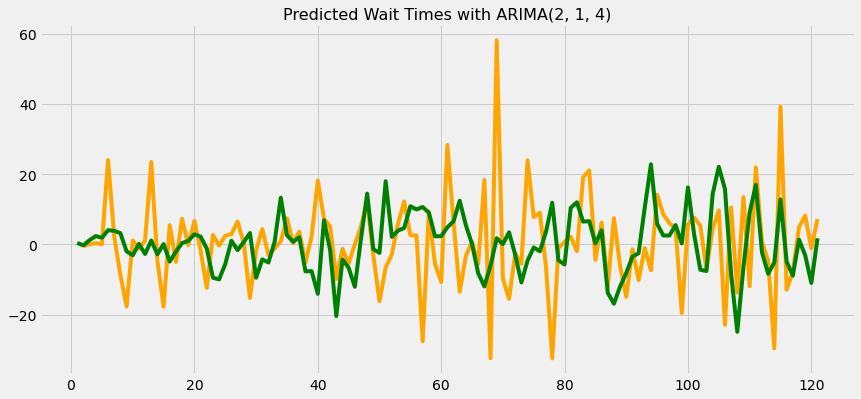

In [88]:
# Plot data.
plt.figure(figsize=(13,6))

# Plot training data.
#plt.plot(y_train.index, pd.DataFrame(y_train).diff(), color = 'blue')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test).diff(), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'Predicted Wait Times with ARIMA(2, 1, 4)', fontsize=16)
plt.show();

The blue line represents 2019 (train) data; the orange line represents 2021 (test) data. The green line represents the predicted wait times.

To plot the two time series on the same timeframe, I replaced the respective date indices with a day_number index, beginning on Aug 30 and ending on Dec 28 of the respective years.

This ARIMA model doesn't do as well as those for Na'vi River Journey and Flight of Passage.  This is reasonable, since there is far more data for Kilimanjaro Safaris, since it opened a few years before the other rides.  There is also a random factor with this ride: Ocasionally, an animal hangs out in the path of a safari vehicle and everything grinds to a halt until the animal clears the path from a safe distance.  This can take anywhere from a few minutes to however long the animal wishes to hang out.  Even with this unpredictability, it appears that the ARIMA model is most accurate around Aug, Nov, and Dec.  September and October's predictions are especially wrong.

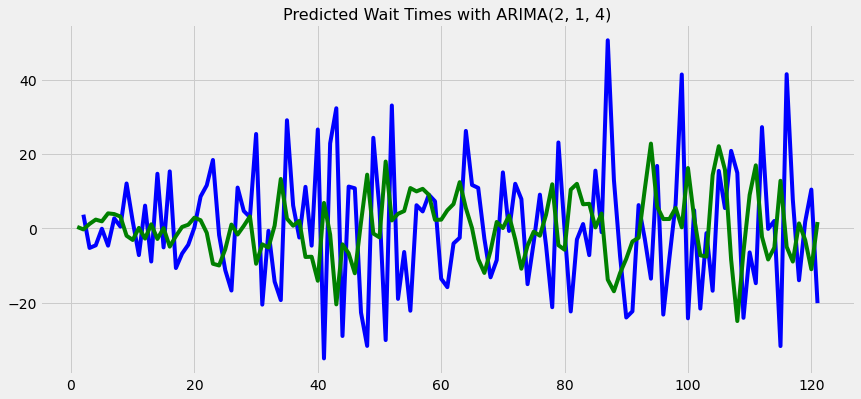

In [89]:
# Plot data.
plt.figure(figsize=(13,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train).diff(), color = 'blue')

# Plot testing data.
#plt.plot(y_test.index, pd.DataFrame(y_test).diff(), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'Predicted Wait Times with ARIMA(2, 1, 4)', fontsize=16)
plt.show();

In [90]:
adfuller(y_train['avg_daily_wait'])

(-4.531258913907022,
 0.00017258808861085088,
 0,
 120,
 {'1%': -3.486055829282407,
  '5%': -2.8859430324074076,
  '10%': -2.5797850694444446},
 895.436702564919)

In [91]:
adfuller(precovid_weekly_3['avg_weekly_wait'])

(-2.0667872946566264,
 0.2580775366901141,
 7,
 200,
 {'1%': -3.463476079125, '5%': -2.876102355, '10%': -2.574532225},
 1395.7136686822746)

With an alpha of .05 and a p-value of .00017, the y_train data are stationary. 

### Mean Absolute Error

In [92]:
#preds_df = pd.DataFrame(arima)
#preds_df.head()

In [93]:
# print(f'Mean absolute error: {preds_df.mae}')
# print(f'Mean squared error: {preds_df.mse}')

Both mean absolute error and mean squared error are low.  This indicates that the model is strong, perhaps because of the high degree of autocorrelation.

In [94]:
# print(preds.summary())

Aug 30, 2021 was a Friday, but August 30, 2019 was a Monday.

## SARIMAX

In [95]:
y_train_sarimax

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2019-07-16,2019-07-16 20:59:01,NaN,10.0,2,Tuesday,2019-07-16,50.217391
2019-07-17,2019-07-17 20:59:02,NaN,10.0,3,Wednesday,2019-07-17,45.346535
2019-07-18,2019-07-18 22:31:02,NaN,15.0,4,Thursday,2019-07-18,36.359649
2019-07-19,2019-07-19 20:59:01,NaN,15.0,5,Friday,2019-07-19,38.200000
2019-07-20,2019-07-20 20:59:02,NaN,25.0,6,Saturday,2019-07-20,42.596154
...,...,...,...,...,...,...,...
2019-12-24,2019-12-24 18:24:02,NaN,25.0,2,Tuesday,2019-12-24,81.948052
2019-12-25,2019-12-25 18:24:02,NaN,25.0,3,Wednesday,2019-12-25,68.000000
2019-12-26,2019-12-26 18:24:02,NaN,30.0,4,Thursday,2019-12-26,69.767442


In [96]:
sarimax_model = pmd.auto_arima(y_train['avg_daily_wait'], m=23, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[23] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[23] intercept   : AIC=1018.536, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[23] intercept   : AIC=1017.602, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[23] intercept   : AIC=1015.082, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[23]             : AIC=1016.586, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[23] intercept   : AIC=1013.179, Time=0.04 sec
 ARIMA(0,1,1)(1,0,0)[23] intercept   : AIC=1015.104, Time=0.12 sec
 ARIMA(0,1,1)(1,0,1)[23] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(1,1,1)(0,0,0)[23] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[23] intercept   : AIC=1007.425, Time=0.04 sec
 ARIMA(0,1,2)(1,0,0)[23] intercept   : AIC=1009.385, Time=0.16 sec
 ARIMA(0,1,2)(0,0,1)[23] intercept   : AIC=1009.379, Time=0.18 sec
 ARIMA(0,1,2)(1,0,1)[23] intercept   : AIC=1011.296, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[23] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[23] intercept   : 

In [97]:
sarimax_model = sm.tsa.statespace.SARIMAX(y_train['avg_daily_wait'], order=(1,1,1), seasonal_order=(0, 0, 0, 23))
safari_results = sarimax_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.13200D+00    |proj g|=  6.66224D-02

At iterate    5    f=  4.11644D+00    |proj g|=  3.71847D-03

At iterate   10    f=  4.11553D+00    |proj g|=  2.49692D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     13      1     0     0   8.102D-06   4.116D+00
  F =   4.1155316401691397     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.


The data are stationary, although there is fluctuation.  There is no seasonality.

## Choose Best Model

In [98]:
# MSE and MAE for Null Model

both_models['null_diff_sq'] = (both_models['null_wait'] - both_models['avg_daily_wait']) ** 2
both_models['abs_null_diff'] = abs(both_models['null_wait'] - both_models['avg_daily_wait'])
null_mse = (both_models['null_diff_sq']).sum()

print(f"Null MSE = {null_mse}")

null_mae = (both_models['abs_null_diff']).sum() / len(both_models)
print(f'Null MAE = {null_mae}')

both_models.head()


NameError: name 'both_models' is not defined

In [ ]:
# MSE and MAE for ARIMA

preds_df = pd.DataFrame(preds)
preds_df.columns = ['pred_off']

preds_df['pred_sq'] = (preds_df['pred_off'])**2
arima_mse = (preds_df['pred_sq']).sum()

preds_df['preds_abs'] = abs(preds_df['pred_off'])
arima_mae = (preds_df['preds_abs']).sum() / len(preds_df)

print(f"ARIMA MSE = {arima_mse}")
print(f"ARIMA MAE = {arima_mae}")

The ARIMA model is the better model by far.

RMSE = .060 - .153, std error of constant = .395
Based on the P values, the data are stationary (alpha = .05)

# Pickle

In [ ]:
safari_arima = arima

In [ ]:
with open('models/safari_arima.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(safari_arima, pickle_out)